# Example Usage

This is a basic example using the torchvision COCO dataset from coco.py, it assumes that you've already downloaded the COCO images and annotations JSON.  You'll notice that the scale augmentations are quite extreme.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from simple_copy_paste import CopyPaste
from coco import CocoDetectionCP
from vizualise import display_instances
import albumentations as A
import random
from matplotlib import pyplot as plt

/Users/erikriise/anaconda3/envs/DiffAug/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
transform = A.Compose(
    [
        A.RandomScale(
            scale_limit=(-0.9, 1), p=1
        ),  # LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(
            256, 256, border_mode=0
        ),  # pads with image in the center, not the top left like the paper
        A.RandomCrop(256, 256),
        CopyPaste(
            blend=True, sigma=1, pct_objects_paste=0.8, p=1.0
        ),  # pct_objects_paste is a guess
    ],
    bbox_params=A.BboxParams(format="coco", min_visibility=0.05),
)

data = CocoDetectionCP(
    "../data/val2017",
    "../data/annotations/instances_val2017.json",
    transform,
)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [18]:
from torch.utils.data import DataLoader

loader = DataLoader(
    data, batch_size=1000, shuffle=False, num_workers=0, collate_fn=data.collate_fn
)

In [19]:
data

Dataset CocoDetectionCP
    Number of datapoints: 4952
    Root location: ../data/val2017
    Compose([
  RandomScale(always_apply=False, p=1, interpolation=1, scale_limit=(-0.9, 1.0)),
  PadIfNeeded(always_apply=False, p=1.0, min_height=256, min_width=256, pad_height_divisor=None, pad_width_divisor=None, position=PositionType.CENTER, border_mode=0, value=None, mask_value=None),
  RandomCrop(always_apply=False, p=1.0, height=256, width=256),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.05, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [20]:
loader_iter = iter(loader)

In [21]:
next_batch = next(loader_iter)

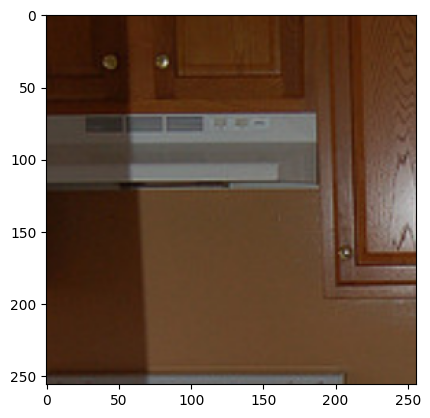

In [24]:
for i in range(1000):
    if len(next_batch[1][i]["boxes"]) == 0:
        plt.imshow(next_batch[0][i].permute(1, 2, 0) / 255)
        break

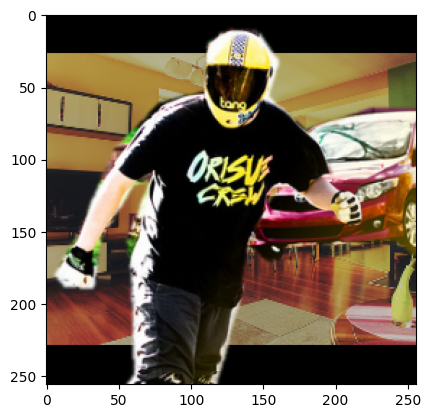

In [9]:
plt.imshow(next_batch[0][0].permute(1, 2, 0) / 255)

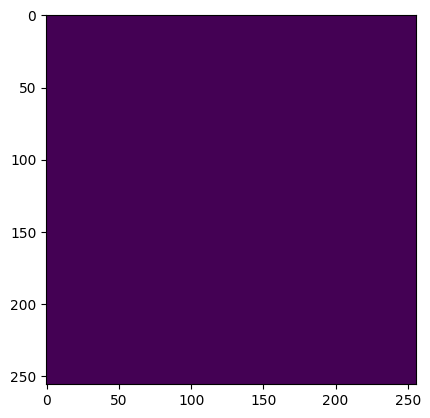

In [31]:
plt.imshow(next_batch[1][0]["masks"][1])

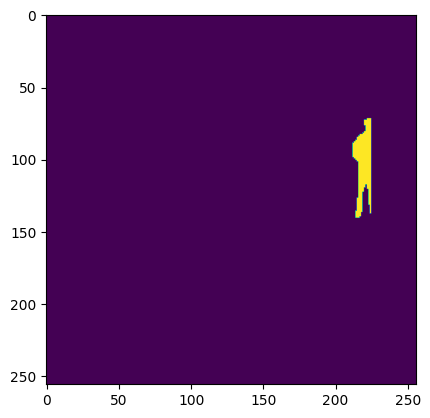

In [35]:
plt.imshow(next_batch[1][0][2])

TypeError: tuple indices must be integers or slices, not str

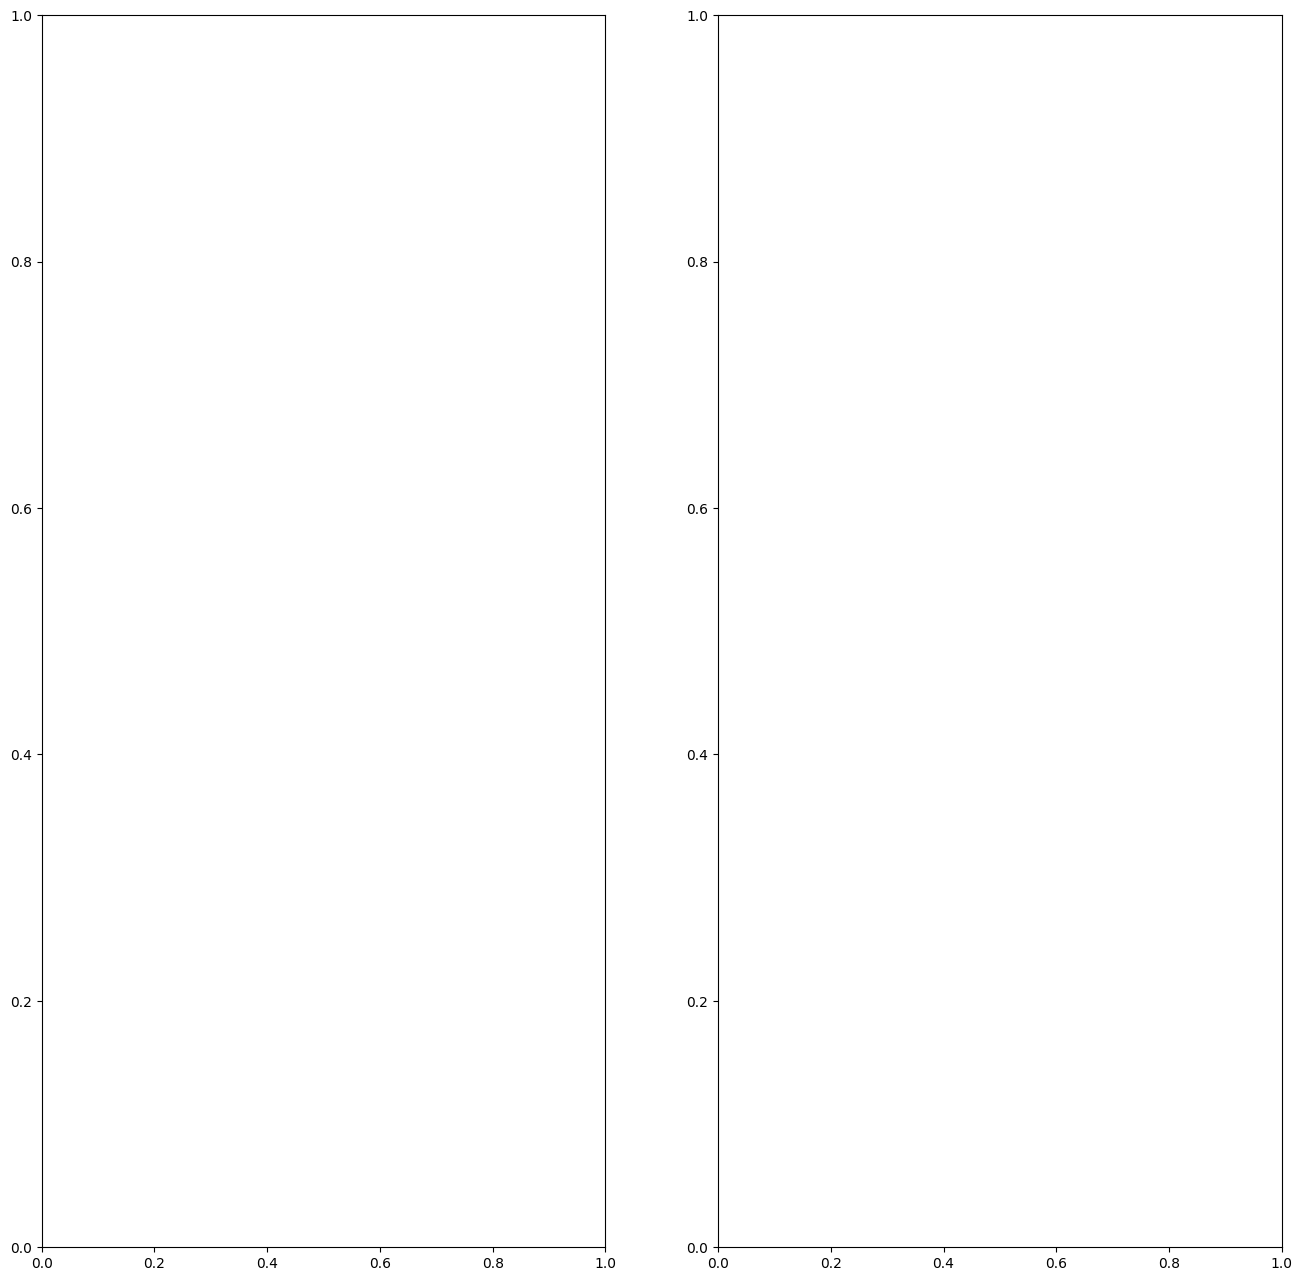

In [25]:
f, ax = plt.subplots(1, 2, figsize=(16, 16))

index = random.randint(0, len(data))
img_data = data[index]
image = img_data[0]
masks = img_data["masks"]
bboxes = img_data["bboxes"]

empty = np.array([])
display_instances(
    image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[0]
)

if len(bboxes) > 0:
    boxes = np.stack([b[:4] for b in bboxes], axis=0)
    box_classes = np.array([b[-2] for b in bboxes])
    mask_indices = np.array([b[-1] for b in bboxes])
    show_masks = np.stack(masks, axis=-1)[..., mask_indices]
    class_names = {k: data.coco.cats[k]["name"] for k in data.coco.cats.keys()}
    display_instances(
        image, boxes, show_masks, box_classes, class_names, show_bbox=True, ax=ax[1]
    )
else:
    display_instances(
        image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[1]
    )

In [47]:
index

2049

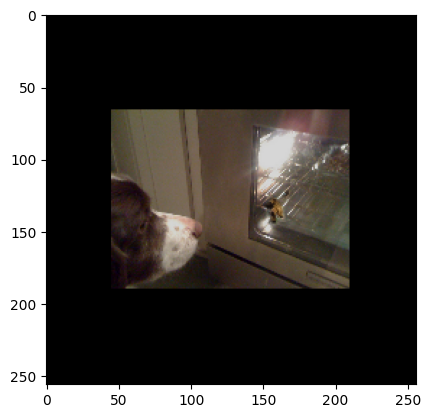

In [67]:
plt.imshow(data[2049]["image"])

In [ ]:
def plot_images_with_boxes_and_masks(images, targets, num_images=2):
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
    for idx in range(num_images):
        img = images[idx].permute(1, 2, 0)  # C,H,W to H,W,C
        img = img.clone().detach().cpu().numpy()
        axs[idx].imshow(img)
        if "masks" in targets[idx]:  # Checking if masks are available in the target
            masks = targets[idx]["masks"]
            for mask in masks:
                mask = mask.squeeze().cpu().numpy()  # Assuming masks are (1, H, W)
                axs[idx].imshow(
                    mask, alpha=0.5, cmap="Blues", vmin=0, vmax=1
                )  # Overlay mask with transparency

        for box in targets[idx]["boxes"]:
            box = box.cpu().numpy()
            rect = patches.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=2,
                edgecolor="r",
                facecolor="none",
            )
            axs[idx].add_patch(rect)
        axs[idx].axis("off")
    plt.tight_layout()
    return fig

In [13]:
# L2 norm

import numpy as np

a = np.array([1, 2, 3])

print(np.linalg.norm(a, 2) ** 2)

print(a.T @ a)

k = 0
for i in a:
    k += i**2
print(k)

print(max(a) ** 2)

print(np.linalg.norm(a, 1))

14.0
14
14
9
6.0
